In [1]:
import torch
import os
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

In [2]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [3]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [4]:
model = torch.load("plant-disease-model-complete.pth")

In [5]:
data_dir = "./data"
train_dir = "./data/train"
valid_dir = "./data/valid"
test_dir = "./data/test"
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [6]:
test_images = sorted(os.listdir(test_dir + "/test"))
test_images

['0001aa74-bbd7-433b-a900-1dccab39d521___FAM_L.Blight 4508.JPG',
 '002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG',
 '0027f9ae-818b-41d1-95c8-9e296bd0fdae___RS_HL 6902.JPG',
 '002f87b7-e1a5-49e5-a422-bb423630ded5___JR_HL 8068.JPG',
 '002ff75b-39d3-45b8-931f-e5f56eeddf03___RS_HL 2848.JPG',
 '00359c66-5d75-40ce-a5b7-6ef05959d2d2___Rut._Bact.S 1381.JPG',
 '003b7929-a364-4e74-be1c-37c4c0a6ec63___Com.G_SpM_FL 1414.JPG',
 '0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG',
 '004cbe60-8ff9-4965-92df-e86694d5e9ba___RS_Erly.B 8253.JPG',
 '00532378-bfb2-4d3b-8b19-903ecc085624___RS_HL 2021.JPG',
 '005e3b43-9050-47da-9498-f9ecdcc703b3___RS_Late.B 5104.JPG',
 '00694db7-3327-45e0-b4da-a8bb7ab6a4b7___Crnl_L.Mold 6923.JPG',
 '008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG',
 '0098dbd9-286a-4d6a-bf4b-5459d66f88c0___RS_HL 5776.JPG',
 '00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG',
 '00a79a7b-8b96-452c-91c8-deb54eaa28e5___CREC_HLB 7231.JPG',
 '00b65fe8-cee1-4b6

In [7]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    # if torch.backends.mps.is_available():
    #     torch.set_default_device("mps")
    #     return torch.device("mps")
    # else:
    torch.set_default_device("cpu")
    return torch.device("cpu")

In [10]:
device = get_default_device()
device

device(type='cpu')

Label: 0001aa74-bbd7-433b-a900-1dccab39d521___FAM_L.Blight 4508.JPG , Predicted: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


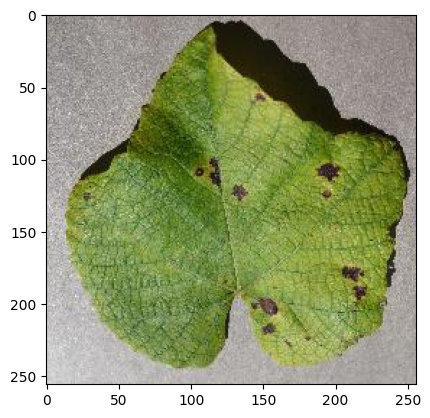

In [11]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))